In [56]:
#Imports Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from scipy.stats import t
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score


In [57]:
# Reading the German credit data from a CSV file into a pandas DataFrame
data = pd.read_csv("german_credit_data.csv")

In [58]:
# List of numerical features
numerical = ['Credit amount','Age','Duration']

# List of categorical features
categorical = ['Gender','Job','Housing','Saving accounts','Checking account','Purpose']

# List of columns to be dropped
unused = ['Unnamed: 0']

print(data['Sex'].isnull().sum())

0


In [59]:
def drop_unused_columns(data, unused_columns):
    """
    Drops unused columns from the DataFrame.
    """
    return data.drop(columns=unused_columns)
data = drop_unused_columns(data, unused)

Statistical Parameters of Numerical Features:
       Credit amount      Age  Duration
count        1000.00  1000.00   1000.00
mean         3271.26    35.55     20.90
std          2822.74    11.38     12.06
min           250.00    19.00      4.00
25%          1365.50    27.00     12.00
50%          2319.50    33.00     18.00
75%          3972.25    42.00     24.00
max         18424.00    75.00     72.00


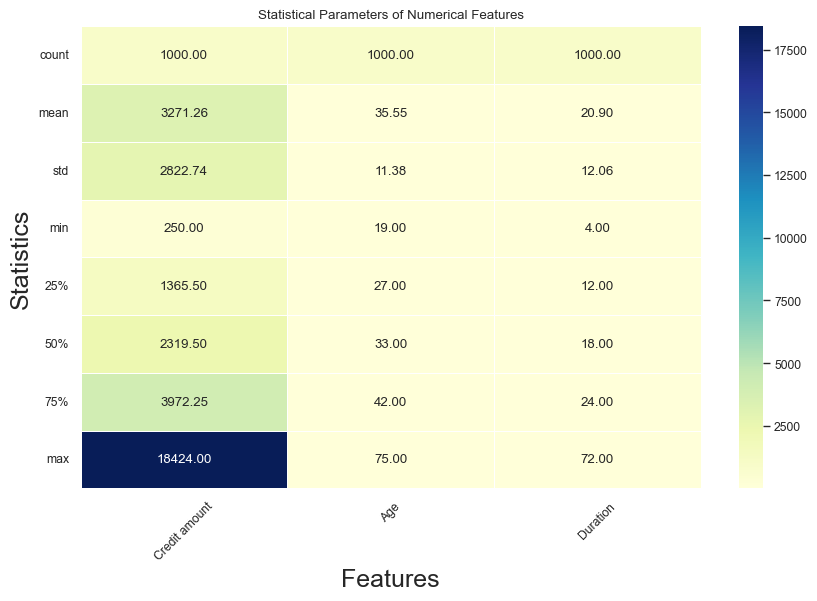

In [60]:
def visualize_numerical_statistics(data, numerical_features, filename):
    """
    Generates and visualizes statistical parameters of numerical features.
    """
    # Generate statistical parameters
    stats = data[numerical_features].describe().round(2)

    # Display the statistical parameters
    print("Statistical Parameters of Numerical Features:")
    print(stats)

    # Visualize the statistical parameters using seaborn or matplotlib
    plt.figure(figsize=(10, 6))
    sns.heatmap(stats, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
    plt.title("Statistical Parameters of Numerical Features")
    plt.xlabel("Features")
    plt.ylabel("Statistics")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()

# Call the method
visualize_numerical_statistics(data, numerical, 'table.png')


C:\Users\behro\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


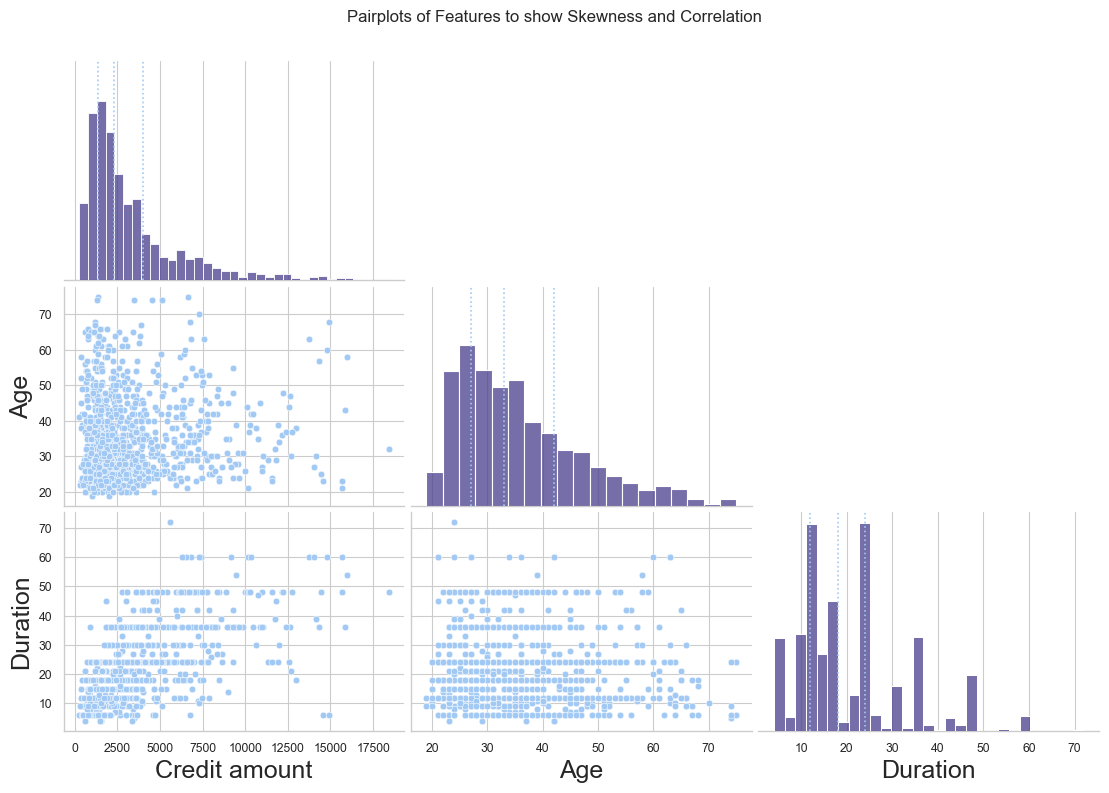

In [61]:
def update_diag_func(data, label, color):
    """
    Update diagonal plots in pairplot with vertical lines representing quartiles.
    """
    for val in data.quantile([.25, .5, .75]):
        plt.axvline(val, ls=':', color=color)

def create_pairplot_with_diag(data, numerical, title, filename):
    """
    Create pairplot with diagonal plots updated to show quartiles.
    """
    sns.set(style='whitegrid')
    sns.set_palette("pastel")
    sns.set_context("paper", rc={"axes.labelsize":18})
    
    sns_pairplot = sns.pairplot(data[numerical], height=2.5, aspect=1.5, diag_kws={'color':'darkslateblue'}, corner=True)
    sns_pairplot.map_diag(update_diag_func)
    
    sns_pairplot.fig.suptitle(title, y=1.05, x=0.5, fontsize=12)
    sns_pairplot.savefig(filename, bbox_inches="tight", dpi=100)

# Example usage:
create_pairplot_with_diag(data, numerical, 'Pairplots of Features to show Skewness and Correlation', 'skewness.png')


In [62]:
# Exclude non-numeric columns
numerical = ['Credit amount', 'Age', 'Duration']
data_numeric = data[numerical]

# Compute correlation matrix
corr = data_numeric.corr(method='pearson')

# Create a mask to hide the lower triangle of the heatmap
mask = np.tril(np.ones_like(corr, dtype=bool))

# Create a DataFrame for clustered data
ds_2_cluster = pd.DataFrame()
ds_2_cluster['Credit amount'] = data['Credit amount']
ds_2_cluster['Age'] = data['Age']
ds_2_cluster['Duration'] = data['Duration']

# Transform data to logarithmic scale
ds_2_cluster_log = np.log(ds_2_cluster[['Age', 'Credit amount','Duration']])


In [63]:
# Fill missing values in 'Saving accounts' and 'Checking account' columns with mode
data['Saving accounts'] = data['Saving accounts'].fillna(data['Saving accounts'].mode()[0])
data['Checking account'] = data['Checking account'].fillna(data['Checking account'].mode()[0])

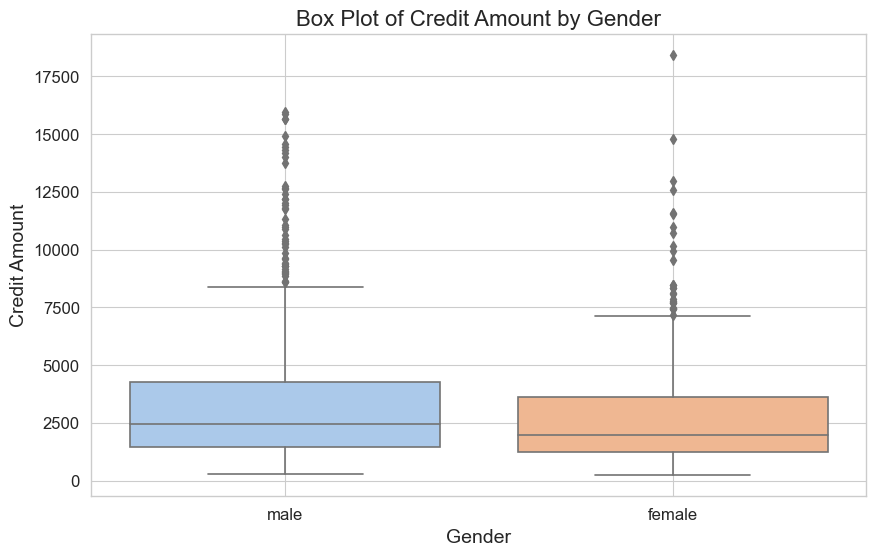

In [64]:
def create_box_plot(data):
    """
    Create a box plot of credit amount by gender.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Sex', y='Credit amount', data=data)
    plt.title('Box Plot of Credit Amount by Gender', fontsize=16)
    plt.xlabel('Gender', fontsize=14)
    plt.ylabel('Credit Amount', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.savefig("box_plot.png", bbox_inches="tight", dpi=300)
    plt.show()

create_box_plot(data)

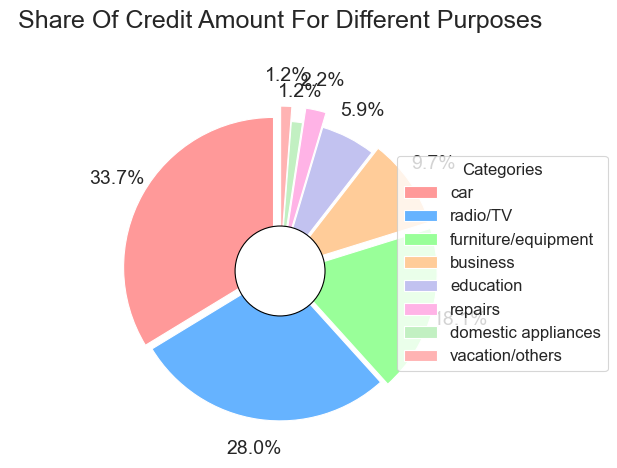

In [65]:
def create_and_save_pie_plot(data, filename):
    """
    Creates and saves a pie chart showing the share of credit amount for different purposes.
    """
    # Define colors for the pie chart
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c2f0c2', '#ffb3b3']

    # Plot a pie chart
    explode = (0.05, 0, 0.05, 0.05, 0, 0.1, 0., 0.1)
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(data.Purpose.value_counts().values, labels=['']*len(data.Purpose.value_counts().index), 
                                      autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14}, pctdistance=1.2,
                                      explode=explode, colors=colors)

    centre_circle = plt.Circle((0, 0), 0.3, edgecolor='black', linewidth=0.8, facecolor='white')  
    ax.add_patch(centre_circle)
    ax.axis('equal')

    # Customize legend
    legend = ax.legend(wedges, data.Purpose.value_counts().index, title="Categories", loc="center left", 
                       bbox_to_anchor=(0.7, 0, 0.5, 1), fontsize=12)
    plt.setp(legend.get_title(), fontsize='12')

    plt.title('Share Of Credit Amount For Different Purposes', fontsize=18, y=1.1, pad=20)
    plt.savefig(filename, bbox_inches="tight", dpi=100)
    plt.tight_layout()
    plt.show()

# Call the method
create_and_save_pie_plot(data, "Pie Plot.png")


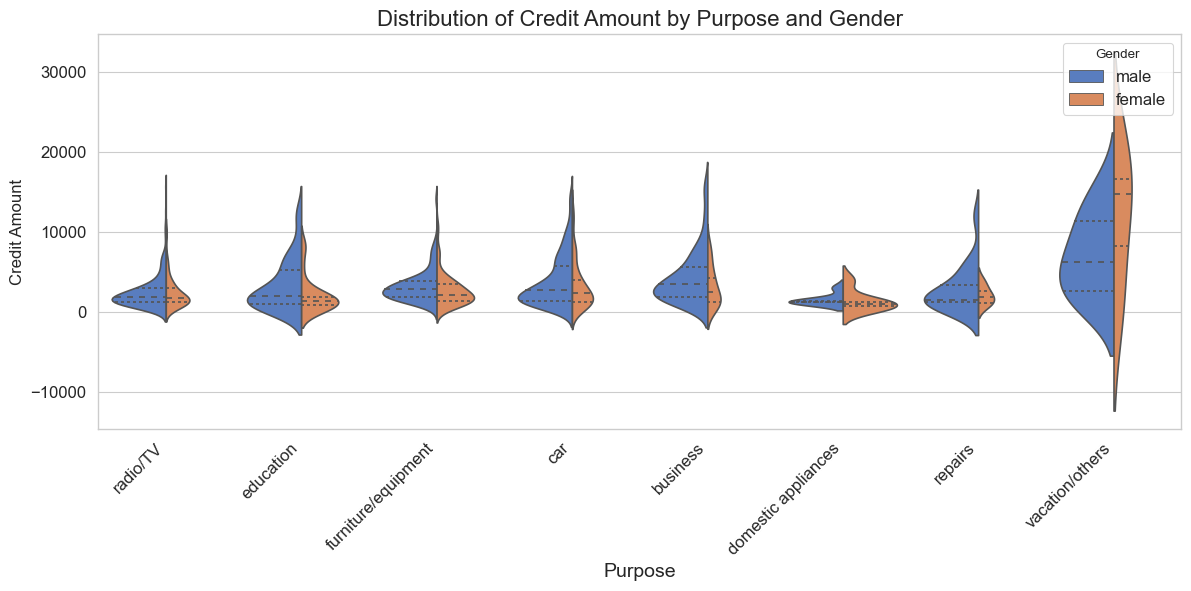

In [66]:
def create_and_save_violin_plot(data, filename):
    """
    Creates and saves a violin plot showing the distribution of credit amount by purpose and gender.
    """
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='Purpose', y='Credit amount', hue='Sex', data=data, split=True, palette='muted', scale='count', inner='quartile')
    plt.title('Distribution of Credit Amount by Purpose and Gender', fontsize=16)
    plt.xlabel('Purpose', fontsize=14)
    plt.ylabel('Credit Amount', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Gender', fontsize=12)
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.tight_layout()
    plt.show()

# Call the method
create_and_save_violin_plot(data, "Violin Plot.png")

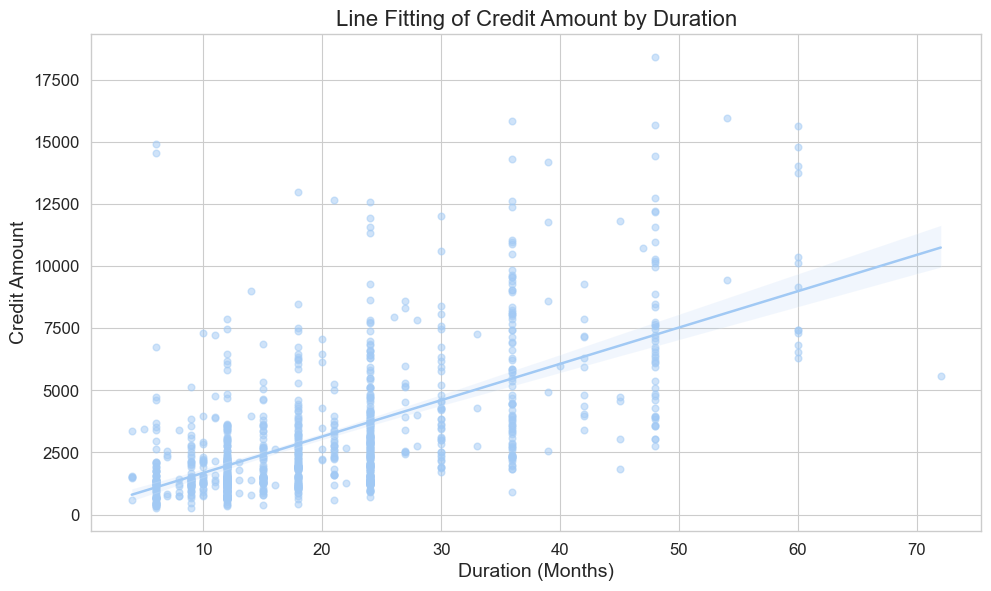

In [67]:
def create_line_fitting_graph(data):
    plt.figure(figsize=(10, 6))
    sns.regplot(x='Duration', y='Credit amount', data=data, scatter_kws={'alpha':0.5})
    plt.title('Line Fitting of Credit Amount by Duration', fontsize=16)
    plt.xlabel('Duration (Months)', fontsize=14)
    plt.ylabel('Credit Amount', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.savefig("Line Fitting.png", bbox_inches="tight", dpi=300)
    plt.tight_layout()

create_line_fitting_graph(data)

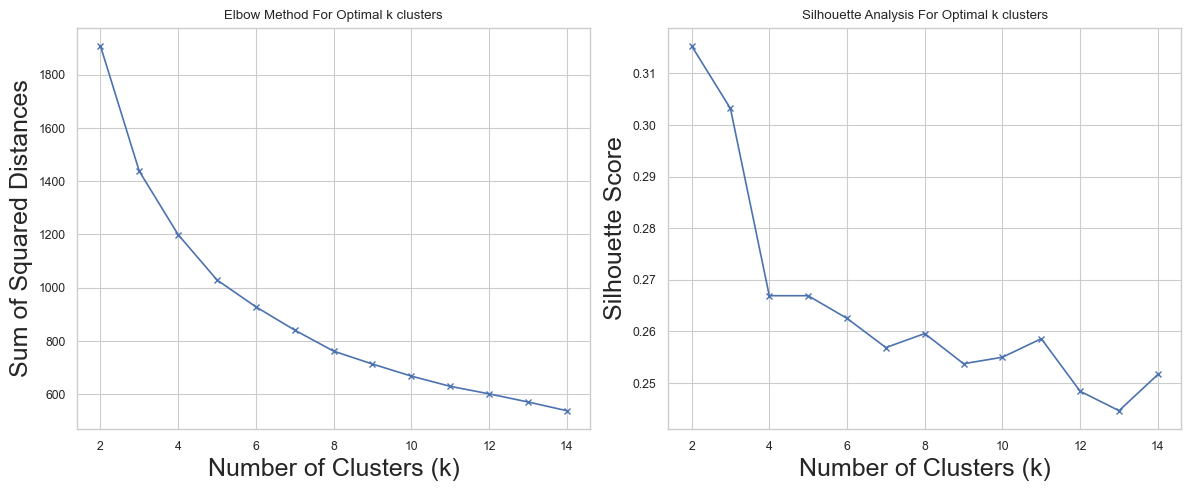

In [71]:
# Determine optimal number of clusters using the Elbow Method
Sum_of_squared_distances = []
silhouette_scores = []
K = range(2, 15)
for k in K:
    # Fit KMeans clustering model
    km = KMeans(n_clusters=k, n_init=10)
    km.fit(cluster_scaled)
    
    # Compute sum of squared distances
    Sum_of_squared_distances.append(km.inertia_)
    
    # Compute silhouette score
    silhouette_scores.append(silhouette_score(cluster_scaled, km.labels_))

# Plot Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k clusters')

# Plot Silhouette Analysis
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k clusters')

plt.tight_layout()
plt.show()


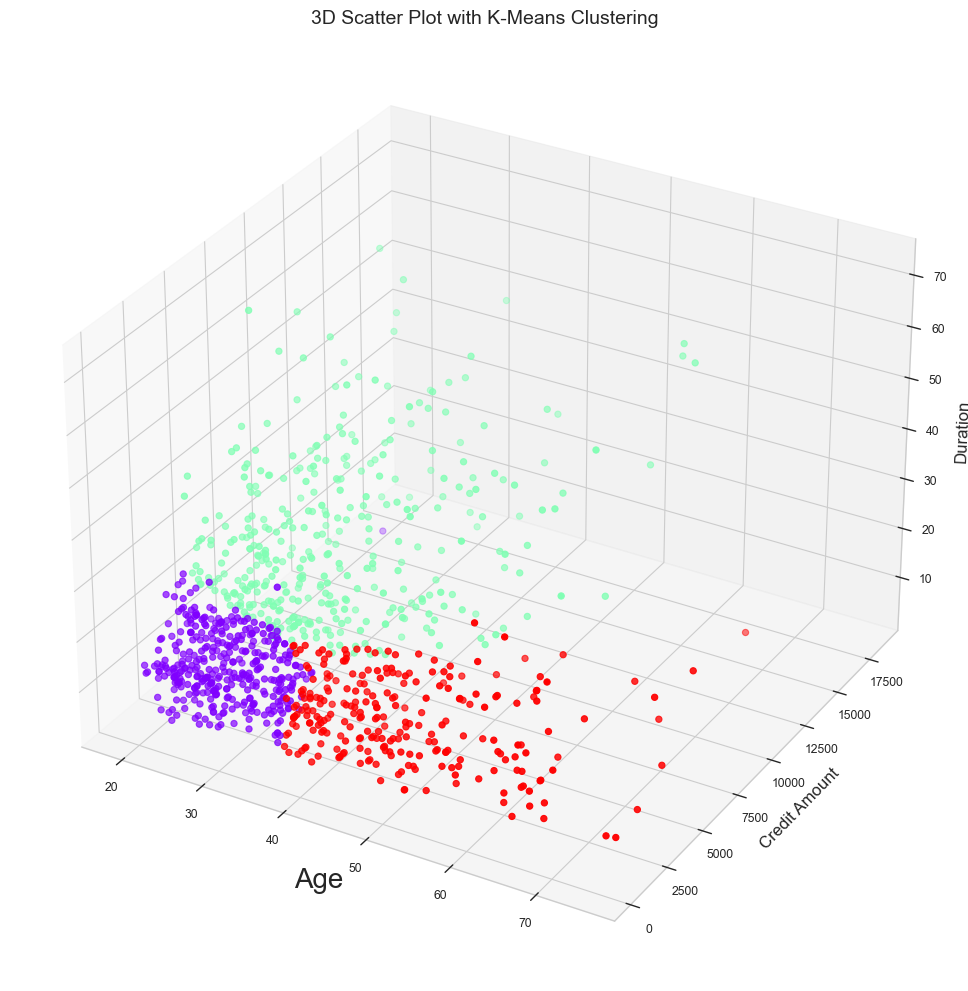

In [69]:
# Scale the data
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(ds_2_cluster_log)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, n_init=10)  # Set n_init explicitly to suppress the warning
kmeans.fit(cluster_scaled)

# Get cluster labels
kmeans_labels = kmeans.labels_

def visualize_3d_scatter_with_clusters(data, kmeans_labels):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data['Age'], data['Credit amount'], data['Duration'], c=kmeans_labels, cmap='rainbow')
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Credit Amount', fontsize=12)
    ax.set_zlabel('Duration', fontsize=12)
    ax.set_facecolor('white')
    plt.title('3D Scatter Plot with K-Means Clustering', fontsize=14)
    plt.tight_layout()
    plt.savefig("3d_scatter_plot_with_clusters.png", bbox_inches="tight", dpi=100)
    plt.show()  # Add this line to display the plot

# Call the function with defined kmeans_labels
visualize_3d_scatter_with_clusters(ds_2_cluster, kmeans_labels)


Mean Squared Error: 3930770.492678247
Coefficients: [ 177.46372765 1822.61601929]
Intercept: 3360.61875


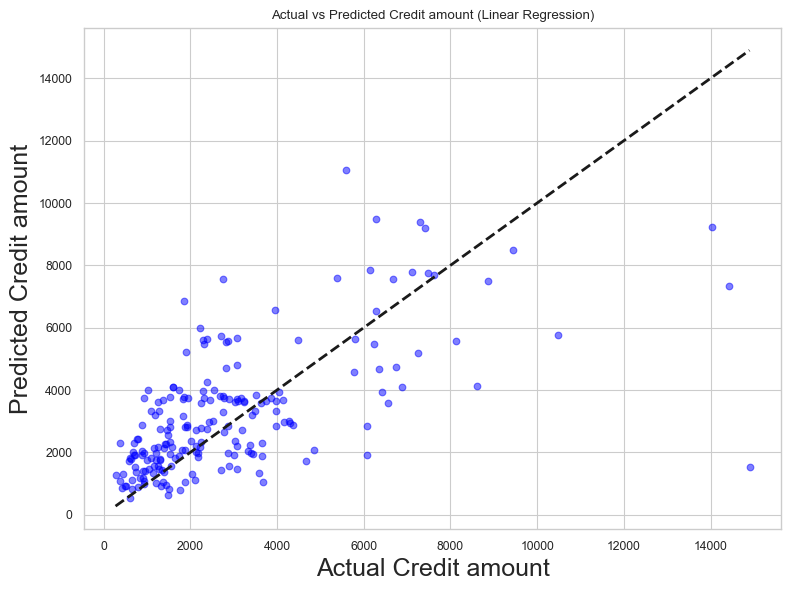

In [70]:
# Select features and target variable
X = data[['Age', 'Duration']]  # Features
y = data['Credit amount']      # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the regression model
regression_model = LinearRegression()
regression_model.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred = regression_model.predict(X_test_scaled)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Optionally, you can also print the coefficients of the model
print("Coefficients:", regression_model.coef_)
print("Intercept:", regression_model.intercept_)


# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Credit amount')
plt.ylabel('Predicted Credit amount')
plt.title('Actual vs Predicted Credit amount (Linear Regression)')
plt.grid(True)
plt.savefig('linear_regression.png', bbox_inches="tight", dpi=100)
plt.tight_layout()
plt.show()